Code Block 1: Setup, Instance Generation, Model Definition

In [2]:
# -*- coding: utf-8 -*-
# Block 1: Setup, Instance Generation (Strict Table 2 Alignment), Model Definition, Plotting

import gurobipy as gp
from gurobipy import GRB
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

print(f"Gurobi Optimizer version: {gp.gurobi.version()}")

# --- Helper Functions ---
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# --- Instance Generation (Strictly Adhering to Table 2 and Derived Sets) ---
def generate_instance_table2_final(num_stores, num_physical_satellites, num_products, num_orders,
                                   vehicle_capacity_V_star, penalty_pu_param, split_ps_param,
                                   seed=42, vehicle_buffer=0): # Default vehicle_buffer to 0, can be adjusted
    random.seed(seed)

    # --- SET DEFINITIONS (as per LaTeX derived from Table 2) ---
    depot_node_0 = 'D0' # Represents node '0'

    set_S_stores = [f"S{s_idx+1}" for s_idx in range(num_stores)]

    # M_T2 (Table 2's M): satellites where 0 denotes the central warehouse
    _physical_sat_nodes_temp = [f"M{m_idx+1}" for m_idx in range(num_physical_satellites)]
    set_M_T2_sats_and_depot = [depot_node_0] + _physical_sat_nodes_temp # This is M in Table 2

    # M_phys = M_T2 \ {0} : Physical satellite locations ONLY
    set_M_phys_physical_satellites = _physical_sat_nodes_temp

    # N_cust = S U M_phys : All CUSTOMER nodes (stores + physical satellites)
    set_N_cust_all_customers = set_S_stores + set_M_phys_physical_satellites

    # N_all = S U M_T2 : All NODES in network (stores + physical satellites + depot)
    set_N_all_network_nodes = list(set(set_S_stores + set_M_T2_sats_and_depot))

    # L_arcs: (i,j) in N_all x N_all, i != j
    set_L_arcs = [(i, j) for i in set_N_all_network_nodes for j in set_N_all_network_nodes if i != j]

    set_R_product_types = [f"P{r_idx+1}" for r_idx in range(num_products)]
    set_B_order_types = [f"B{b_idx+1}" for b_idx in range(num_orders)]

    # --- PARAMETERS ---
    param_coords = {depot_node_0: (0, 0)}
    for i_node in set_S_stores: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25)) # Smaller range
    for i_node in set_M_phys_physical_satellites: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25))

    param_d_ij_dist = {}; param_t_ij_time = {}; max_travel_t_val = 0
    for i_node, j_node in set_L_arcs:
        dist_val = euclidean_distance(param_coords[i_node], param_coords[j_node])
        param_d_ij_dist[i_node, j_node] = dist_val
        param_t_ij_time[i_node, j_node] = dist_val # Assuming speed = 1
        max_travel_t_val = max(max_travel_t_val, param_t_ij_time[i_node, j_node])
    for i_node in set_N_all_network_nodes : param_d_ij_dist[i_node,i_node]=0; param_t_ij_time[i_node,i_node]=0

    param_o_i_service = {node: 0 for node in set_N_all_network_nodes} # o_0 = 0 for depot
    total_serv_t_val = 0
    for node_cust in set_N_cust_all_customers:
        param_o_i_service[node_cust] = random.uniform(3, 10) # Smaller service times
        total_serv_t_val += param_o_i_service[node_cust]

    param_V_r_volume = {r_prod: random.randint(1, 3) for r_prod in set_R_product_types} # V_r
    param_V_b_volume = {b_ord: random.randint(1, 3) for b_ord in set_B_order_types} # V_b

    param_D_i_r_S_demand = {}; total_vol_demand_S = 0 # D_i^r (store i, product r)
    for j_store in set_S_stores:
        for r_prod in set_R_product_types:
            demand_val = random.randint(3, 10)
            param_D_i_r_S_demand[j_store, r_prod] = demand_val
            total_vol_demand_S += param_V_r_volume[r_prod] * demand_val

    param_D_i_b_Mphys_demand = {}; total_vol_demand_M_phys = 0 # D_i^b (satellite i, order b)
    for j_sat_phys in set_M_phys_physical_satellites:
        for b_ord in set_B_order_types:
            demand_val = random.randint(3, 10)
            param_D_i_b_Mphys_demand[j_sat_phys, b_ord] = demand_val
            total_vol_demand_M_phys += param_V_b_volume[b_ord] * demand_val

    total_overall_demand_vol = total_vol_demand_S + total_vol_demand_M_phys

    param_l_i_deadline = {} # l_i
    max_deadln_val = 0
    for node_cust in set_N_cust_all_customers:
        min_req_t = param_t_ij_time.get((depot_node_0, node_cust), float('inf')) + param_o_i_service.get(node_cust, 0)
        base_deadln_val = min_req_t + random.uniform(15, 50) # Tighter deadlines
        param_l_i_deadline[node_cust] = max(min_req_t + 0.1, base_deadln_val) # Ensure feasible by a small margin
        max_deadln_val = max(max_deadln_val, param_l_i_deadline[node_cust])
    param_l_i_deadline[depot_node_0] = max_deadln_val + max_travel_t_val + total_serv_t_val # Deadline for depot for Big-M

    # Fleet size VF based on Paper Eq. (1)
    numerator_eq1 = 0
    for r_prod in set_R_product_types:
        for j_store in set_S_stores:
            numerator_eq1 += param_V_r_volume[r_prod] * param_D_i_r_S_demand.get((j_store, r_prod), 0)
    for j_sat_phys in set_M_phys_physical_satellites:
        for b_ord in set_B_order_types:
            numerator_eq1 += param_V_b_volume[b_ord] * param_D_i_b_Mphys_demand.get((j_sat_phys, b_ord), 0)
    
    min_vehicles_eq1_val = 0
    if vehicle_capacity_V_star > 0:
        min_vehicles_eq1_val = math.ceil(numerator_eq1 / vehicle_capacity_V_star)
    else: # Fallback if V_star is 0 or negative
        min_vehicles_eq1_val = len(set_N_cust_all_customers) # Ensure at least one vehicle per customer if capacity is weird
        print(f"Warning: vehicle_capacity_V_star is {vehicle_capacity_V_star}. Using fallback for min_vehicles_eq1_val.")


    num_vehicles_in_fleet = int(min_vehicles_eq1_val + vehicle_buffer)
    set_VF_fleet = [f"K{k_idx+1}" for k_idx in range(num_vehicles_in_fleet)]

    param_M_TIME_for_big_M = param_l_i_deadline[depot_node_0] * 1.5 # Ensure it's large enough

    instance_data = {
        "S_stores": set_S_stores, "M_T2_sats_and_depot": set_M_T2_sats_and_depot,
        "M_phys_satellites": set_M_phys_physical_satellites, "N_cust_customers": set_N_cust_all_customers,
        "N_all_network_nodes": set_N_all_network_nodes, "L_arcs": set_L_arcs,
        "depot_node": depot_node_0, "R_product_types": set_R_product_types,
        "B_order_types": set_B_order_types, "VF_fleet": set_VF_fleet,
        "coords": param_coords, "d_ij": param_d_ij_dist, "t_ij": param_t_ij_time, # Renamed t_ij_travel to t_ij
        "o_i": param_o_i_service, "V_r": param_V_r_volume, # Renamed v_r_volume to V_r
        "V_b": param_V_b_volume, "D_i_r": param_D_i_r_S_demand, # Renamed D_jr_S_demand to D_i_r
        "D_i_b": param_D_i_b_Mphys_demand, "l_i": param_l_i_deadline, # Renamed l_j_deadline to l_i
        "V_star": vehicle_capacity_V_star, "p_u": penalty_pu_param, # Renamed
        "p_s": split_ps_param, "M_TIME_BIG": param_M_TIME_for_big_M, # Renamed
        "total_demand_vol_overall": total_overall_demand_vol, "min_vehicles_eq1": min_vehicles_eq1_val,
        "vehicle_buffer": vehicle_buffer # Store buffer for sensitivity
    }
    return instance_data

# --- VRPOR Model Building Function (Strict Table 2 Alignment) ---
def solve_vrpor_table2_final(instance, time_limit=60, mip_gap=0.001, log_to_console=0):
    S = instance["S_stores"]; M_T2 = instance["M_T2_sats_and_depot"]; M_phys = instance["M_phys_satellites"]
    N_cust = instance["N_cust_customers"]; N_all = instance["N_all_network_nodes"]
    L_arcs_set = instance["L_arcs"]; depot = instance["depot_node"]
    R_set = instance["R_product_types"]; B_set = instance["B_order_types"]; VF_set = instance["VF_fleet"]
    d_ij = instance["d_ij"]; t_ij = instance["t_ij"]; o_i = instance["o_i"]
    V_r = instance["V_r"]; V_b = instance["V_b"]; D_i_r = instance["D_i_r"] # Demands for stores
    D_i_b = instance["D_i_b"]; l_i = instance["l_i"]; V_star = instance["V_star"] # Demands for satellites
    p_u = instance["p_u"]; p_s = instance["p_s"]; M_BIG = instance["M_TIME_BIG"]

    model = gp.Model("VRPOR_Table2_StrictFinal_Improved")
    model.Params.LogToConsole = log_to_console
    model.Params.TimeLimit = time_limit; model.Params.MIPGap = mip_gap; model.Params.NonConvex = 2

    # --- Decision Variables (as per LaTeX Table 2) ---
    x = model.addVars(L_arcs_set, VF_set, vtype=GRB.BINARY, name="x") # x_ij^k
    Q = model.addVars(S, VF_set, R_set, vtype=GRB.INTEGER, lb=0.0, name="Q") # Q_j^kr (j in S)
    Y = model.addVars(M_phys, VF_set, B_set, vtype=GRB.INTEGER, lb=0.0, name="Y") # Y_j^kb (j in M_phys)
    t_arrival = model.addVars(N_all, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_k_j") # t_j^k (all nodes for consistency with Eq12)

    # --- Auxiliary Variables for Objective ---
    # For (t_j^k - l_j)^+ part of penalty term
    t_minus_l_positive = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_minus_l_pos")
    # For sum_{b in B} V_b Y_j^kb part of penalty term
    volume_Y_jk = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="vol_Y_jk")
    # For ((sum_k sum_i x_ij^k) - 1)^+ part of split cost
    total_arrivals_at_j = model.addVars(N_cust, vtype=GRB.INTEGER, lb=0.0, name="total_arrivals_j")
    extra_arrivals_at_j_positive = model.addVars(N_cust, vtype=GRB.CONTINUOUS, lb=0.0, name="extra_arrivals_j_pos")
    
    zero_var = model.addVar(lb=0.0, ub=0.0, name="zero_constant_for_max") # Helper for max(A,0)

    # --- Objective Function (Eq. 2 from LaTeX) ---
    term1_travel_cost = gp.quicksum(d_ij[i_node,j_node] * x[i_node,j_node,k_veh]
                                   for (i_node,j_node) in L_arcs_set for k_veh in VF_set)

    # Define auxiliary variables for bi-linear term
    for j_sat in M_phys:
        for k_veh in VF_set:
            model.addConstr(t_minus_l_positive[j_sat, k_veh] >= t_arrival[j_sat, k_veh] - l_i[j_sat], name=f"def_t_minus_l_pos_{j_sat}_{k_veh}")
            model.addConstr(volume_Y_jk[j_sat, k_veh] == gp.quicksum(V_b[b_ord] * Y[j_sat, k_veh, b_ord]
                                                                    for b_ord in B_set if (j_sat,k_veh,b_ord) in Y), name=f"def_vol_Y_{j_sat}_{k_veh}")
    term2_penalty_cost = gp.quicksum(p_u * t_minus_l_positive[j_sat, k_veh] * volume_Y_jk[j_sat, k_veh]
                                      for j_sat in M_phys for k_veh in VF_set)

    # Define auxiliary variables for split cost term
    for j_node_cust in N_cust:
        model.addConstr(total_arrivals_at_j[j_node_cust] == gp.quicksum(x[i_node, j_node_cust, k_veh]
                                                                    for (i_node, _j) in L_arcs_set if _j == j_node_cust # Sum over i for fixed j
                                                                    for k_veh in VF_set), name=f"def_total_arrivals_{j_node_cust}")
        # (A - 1)+ = max(A-1, 0)
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= total_arrivals_at_j[j_node_cust] - 1, name=f"def_extra_arr_ge_m1_{j_node_cust}")
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= zero_var, name=f"def_extra_arr_ge_0_{j_node_cust}") # Ensures positive for max
        # Gurobi's max_ function can also be used if preferred: model.addConstr(extra_arrivals_at_j_positive[j_node_cust] == gp.max_(total_arrivals_at_j[j_node_cust] - 1, zero_var), name=f"def_extra_arrivals_max_{j_node_cust}")

    term3_split_cost = p_s * gp.quicksum(extra_arrivals_at_j_positive[j_node_cust] for j_node_cust in N_cust)

    model.setObjective(term1_travel_cost + term2_penalty_cost + term3_split_cost, GRB.MINIMIZE)

    # --- Constraints (Eqs. 3-16 from LaTeX) ---
    # Eq. 3
    model.addConstr(gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set for k_veh in VF_set) <= len(VF_set), "PaperEq3_TotalDepartures")

    # Eq. 4
    for k_veh in VF_set:
        sum_out_depot = gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set)
        sum_in_depot  = gp.quicksum(x[i_node_cust,depot,k_veh] for i_node_cust in N_cust if (i_node_cust,depot) in L_arcs_set)
        model.addConstr(sum_out_depot == sum_in_depot, f"PaperEq4_ReturnToDepot_{k_veh}")
        model.addConstr(sum_out_depot <= 1, f"PaperEq4_DepartDepotOnce_{k_veh}")

    # Eq. 5
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            model.addConstr(gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust) <= 1, f"PaperEq5_VisitCustOncePerVeh_{k_veh}_{j_node_cust}")

    # Eq. 6
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            inflow_j = gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust)
            outflow_j = gp.quicksum(x[j_node_cust,l_node,k_veh] for l_node in N_all if (j_node_cust,l_node) in L_arcs_set and l_node != j_node_cust)
            model.addConstr(inflow_j - outflow_j == 0, f"PaperEq6_FlowConservation_{k_veh}_{j_node_cust}")

    # Eq. 7
    for j_store in S:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_store, k_veh] for i_node in N_all if (i_node, j_store) in L_arcs_set and i_node != j_store)
            for r_prod in R_set:
                if (j_store, r_prod) in D_i_r: # Check if demand exists
                     model.addConstr(Q[j_store, k_veh, r_prod] <= D_i_r[j_store, r_prod] * vehicle_visits_j, f"PaperEq7_LinkQtoX_{j_store}_{k_veh}_{r_prod}")

    # Eq. 8
    for j_sat in M_phys:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_sat, k_veh] for i_node in N_all if (i_node, j_sat) in L_arcs_set and i_node != j_sat)
            for b_ord in B_set:
                 if (j_sat, b_ord) in D_i_b: # Check if demand exists
                    model.addConstr(Y[j_sat, k_veh, b_ord] <= D_i_b[j_sat, b_ord] * vehicle_visits_j, f"PaperEq8_LinkYtoX_{j_sat}_{k_veh}_{b_ord}")

    # Eq. 9
    for k_veh in VF_set:
        volume_products_Q = gp.quicksum(V_r[r_prod] * Q[j_store,k_veh,r_prod] for j_store in S for r_prod in R_set if (j_store,k_veh,r_prod) in Q)
        volume_orders_Y = gp.quicksum(V_b[b_ord] * Y[j_sat,k_veh,b_ord] for j_sat in M_phys for b_ord in B_set if (j_sat,k_veh,b_ord) in Y)
        model.addConstr(volume_products_Q + volume_orders_Y <= V_star, f"PaperEq9_VehicleCapacity_{k_veh}")

    # Eq. 10
    for j_store in S:
        for r_prod in R_set:
            if (j_store, r_prod) in D_i_r: # Check if demand exists
                model.addConstr(gp.quicksum(Q[j_store,k_veh,r_prod] for k_veh in VF_set if (j_store,k_veh,r_prod) in Q) == D_i_r[j_store,r_prod], f"PaperEq10_DemandSat_S_{j_store}_{r_prod}")

    # Eq. 11
    for j_sat in M_phys:
        for b_ord in B_set:
             if (j_sat, b_ord) in D_i_b: # Check if demand exists
                model.addConstr(gp.quicksum(Y[j_sat,k_veh,b_ord] for k_veh in VF_set if (j_sat,k_veh,b_ord) in Y) == D_i_b[j_sat,b_ord], f"PaperEq11_DemandSat_Mphys_{j_sat}_{b_ord}")

    # Eq. 12 (Time propagation with Big-M)
    model.addConstrs((t_arrival[depot,k_veh] == 0 for k_veh in VF_set), name="TimeAtDepotIsZero_Eq12_base")
    for k_veh in VF_set:
        for j_node_cust in N_cust: # For j in S U M/{0}
            for i_node in N_all: # Sum over i in N_all (S U M in paper)
                if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust :
                     # t_j^k >= t_i^k + o_i + t_ij - M(1-x_ij^k)
                    model.addConstr(t_arrival[j_node_cust,k_veh] >= t_arrival[i_node,k_veh] + o_i.get(i_node,0) + t_ij.get((i_node,j_node_cust),0) - M_BIG*(1-x[i_node,j_node_cust,k_veh]), f"PaperEq12_TimeProp_{k_veh}_{i_node}_{j_node_cust}")

    # Eq. 13 (Hard time window for stores S with Big-M)
    for k_veh in VF_set:
        for j_store in S:
            # t_j^k <= l_j + M(1 - sum_i x_ij^k)
            # sum_i x_ij^k is 1 if store j is visited by vehicle k, 0 otherwise.
            is_visited_by_k = gp.quicksum(x[i_node,j_store,k_veh] for i_node in N_all if (i_node,j_store) in L_arcs_set and i_node != j_store)
            model.addConstr(t_arrival[j_store,k_veh] <= l_i[j_store] + M_BIG*(1-is_visited_by_k), f"PaperEq13_HardTW_S_{k_veh}_{j_store}")
    
    # Eq. 14 (x binary), Eq. 15 (Y integer), Eq. 16 (Q integer) are handled by var definitions.

    # Symmetry Breaking (optional, but can help)
    for k_idx in range(len(VF_set)-1):
        k_curr, k_next = VF_set[k_idx], VF_set[k_idx+1]
        # Force earlier vehicles to be used before later ones
        sum_departs_curr = gp.quicksum(x[depot, jc, k_curr] for jc in N_cust if (depot, jc) in L_arcs_set)
        sum_departs_next = gp.quicksum(x[depot, jc, k_next] for jc in N_cust if (depot, jc) in L_arcs_set)
        model.addConstr(sum_departs_next <= sum_departs_curr, f"SymmetryBreaking_VehOrder_{k_curr}_{k_next}")


    start_time=time.time();model.optimize();end_time=time.time();solve_duration=end_time-start_time
    results={"instance":instance,"model":model,"status_code":model.status,"solve_time":solve_duration,"status_message":{GRB.OPTIMAL:"Optimal",GRB.TIME_LIMIT:"Time Limit Reached",GRB.INTERRUPTED:"Interrupted",GRB.INFEASIBLE:"Infeasible",GRB.UNBOUNDED:"Unbounded",GRB.INF_OR_UNBD:"Infeasible or Unbounded"}.get(model.status,f"Unknown Status ({model.status})")}
    if model.status in [GRB.OPTIMAL,GRB.TIME_LIMIT,GRB.INTERRUPTED] and model.SolCount>0:
        results.update({"objective_value":model.ObjVal,"runtime":model.Runtime,"mip_gap":model.MIPGap,"node_count":model.NodeCount})
        
        sol_x_val={ k_sol_tuple : k_sol_var.X for k_sol_tuple,k_sol_var in x.items() if k_sol_var.X > 0.5 }
        sol_Q_val={k_sol:v.X for k_sol,v in Q.items() if v.X>0.5}
        sol_Y_val={k_sol:v.X for k_sol,v in Y.items() if v.X>0.5}
        sol_t_val={k_sol:v.X for k_sol,v in t_arrival.items()} # Get all arrival times
        
        sol_late_plus_val = {}
        if hasattr(t_minus_l_positive, 'items'): # Check if var was added (e.g. if M_phys is not empty)
            sol_late_plus_val={k_s:v.X for k_s,v in t_minus_l_positive.items() if v.X > 1e-6}
        
        sol_extra_arrivals_val = {}
        if hasattr(extra_arrivals_at_j_positive, 'items'):
             sol_extra_arrivals_val={k_s:v.X for k_s,v in extra_arrivals_at_j_positive.items() if v.X > 0.5} # Should be integer-like

        sol_volY_kj_val = {}
        if hasattr(volume_Y_jk, 'items'):
            sol_volY_kj_val={k_s:v.X for k_s,v in volume_Y_jk.items() if v.X > 1e-4}

        results["solution"]={"x":sol_x_val,"Q":sol_Q_val,"Y":sol_Y_val,"t_arrival":sol_t_val,
                             "lateness_positive_part":sol_late_plus_val,
                             "split_extra_visits_image":sol_extra_arrivals_val,
                             "total_volume_Y_jk_for_penalty":sol_volY_kj_val}


        obj_T_calc=sum(d_ij[i,j]*x_val for (i,j,k),x_val in sol_x_val.items() if (i,j) in d_ij)
        obj_P_calc=sum(p_u*sol_late_plus_val.get((jm,kv),0)*sol_volY_kj_val.get((jm,kv),0) for jm in M_phys for kv in VF_set)
        obj_S_calc=sum(p_s*val for jc,val in sol_extra_arrivals_val.items())
        results["objective_components"]={"travel":obj_T_calc,"penalty":obj_P_calc,"split":obj_S_calc,"calculated_total":obj_T_calc+obj_P_calc+obj_S_calc}

        routes_found={}; cust_served_set=set()
        for k_v_rt in VF_set:
            departs_d = any(sol_x_val.get(((depot,jc,k_v_rt)),0)>0.5 for jc in N_cust if (depot,jc) in L_arcs_set)
            if departs_d:
                rt_k_list=[depot];curr_node_rt=depot;visited_nodes_rt={depot}
                for _ in range(len(N_all)+2): # Max possible nodes + depot return
                    next_node_sel=None
                    # Iterate through L_arcs_set to find outgoing arc for current_node_rt
                    for i_arc_rt, j_arc_rt in L_arcs_set:
                        if i_arc_rt == curr_node_rt and sol_x_val.get(((i_arc_rt,j_arc_rt,k_v_rt)),0)>0.5:
                            # Prefer non-visited node, or depot if it's the only option to close loop
                            if j_arc_rt not in visited_nodes_rt or (j_arc_rt == depot and len(rt_k_list) > 1):
                                next_node_sel=j_arc_rt; break
                    if not next_node_sel: # Could be end of path not at depot, or only visited nodes left
                        if curr_node_rt != depot and (curr_node_rt, depot) in L_arcs_set and sol_x_val.get(((curr_node_rt,depot,k_v_rt)),0)>0.5:
                             if depot not in visited_nodes_rt or len(rt_k_list) > 1 : # Allow returning to depot
                                rt_k_list.append(depot)
                        break
                    rt_k_list.append(next_node_sel)
                    if next_node_sel != depot : visited_nodes_rt.add(next_node_sel) # Don't mark depot as "visited" to allow return
                    if next_node_sel in N_cust:cust_served_set.add(next_node_sel)
                    curr_node_rt=next_node_sel
                    if curr_node_rt==depot and len(rt_k_list)>1 :break # Route ended at depot
                
                # Refined route validation
                if len(rt_k_list)>2 and rt_k_list[0]==depot and rt_k_list[-1]==depot:
                    routes_found[k_v_rt]=rt_k_list
                elif len(rt_k_list)>1 and rt_k_list[0]==depot: # Started from depot but might not have returned
                    # Attempt to add depot if it's the only logical next step
                    final_node = rt_k_list[-1]
                    if final_node != depot and (final_node, depot) in L_arcs_set and sol_x_val.get(((final_node, depot, k_v_rt)), 0) > 0.5:
                        rt_k_list.append(depot)
                        if rt_k_list[0] == depot and rt_k_list[-1] == depot:
                             routes_found[k_v_rt]=rt_k_list
                        else: print(f"Warning: Route {k_v_rt} seems incomplete after trying to close: {rt_k_list}")
                    elif final_node != depot:
                        print(f"Warning: Route {k_v_rt} is incomplete or open: {rt_k_list}")


        results["routes"]=routes_found;results["nodes_served"]=len(cust_served_set)
    else:results.update({"objective_value":None,"runtime":model.Runtime,"mip_gap":None,"node_count":model.NodeCount if hasattr(model,'NodeCount') else None,"solution":None,"routes":None,"nodes_served":0,"objective_components":None})
    return results

# --- Results Printing and Plotting Functions (No change needed in these usually, but check keys) ---
def print_results_summary(results):
    print("\n--- Optimization Summary ---")
    print(f"Status: {results.get('status_message', 'N/A')} (Code: {results.get('status_code', 'N/A')})")
    obj_val = results.get("objective_value")
    if obj_val is not None:
        print(f"Objective Value: {obj_val:.2f}")
        obj_comp = results.get("objective_components")
        if obj_comp: print(f"  Components: Travel={obj_comp['travel']:.2f}, Penalty={obj_comp['penalty']:.2f}, Split={obj_comp['split']:.2f} (Calc Sum: {obj_comp['calculated_total']:.2f})")
        else: print("  Objective components not calculated.")
        print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s")
        print(f"MIP Gap: {results.get('mip_gap','N/A'):.4f}" if results.get('mip_gap') is not None else "MIP Gap: N/A")
        print(f"Nodes Explored: {results.get('node_count','N/A')}")
        print(f"Nodes Served: {results.get('nodes_served','N/A')} / {len(results['instance']['N_cust_customers'])}")
        routes = results.get("routes"); sol = results.get("solution")
        if routes: print(f"\nRoutes Found ({len(routes)}):"); [print(f"  {k}: {' -> '.join(route)}") for k,route in routes.items()]
        else: print("\nNo valid routes extracted.")
        if sol:
             split_visits_img = sol.get("split_extra_visits_image")
             lateness_pos_part_vals = sol.get("lateness_positive_part")
             if split_visits_img and any(v > 0.5 for v in split_visits_img.values()): print("\nSplit Deliveries (Extra Visits > 0):"); [print(f"  Node {j}: {int(round(extra))} extra visit(s)") for j, extra in split_visits_img.items() if extra > 0.5]
             if lateness_pos_part_vals and any(v > 1e-4 for v in lateness_pos_part_vals.values()): print("\nLate Deliveries at Satellites (Lateness > 0):"); [print(f"  Node {jk[0]} by Veh {jk[1]}: {val:.2f} time units late") for jk, val in lateness_pos_part_vals.items() if val > 1e-4]
    else:
        print("No feasible solution found or optimization failed."); print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s"); print(f"Nodes Explored: {results.get('node_count','N/A')}")
    print("--------------------------\n")

def plot_solution_routes(results):
    instance = results.get("instance"); routes = results.get("routes")
    if not instance or not routes: print("Cannot plot: Missing instance or routes."); return
    coords = instance["coords"]; depot = instance["depot_node"]
    S_nodes = instance["S_stores"]; M_nodes = instance["M_phys_satellites"] # Correct key
    plt.figure(figsize=(12,10)); plt.scatter(coords[depot][0], coords[depot][1], c='black', marker='s', s=150, label=f'Depot ({depot})', zorder=5)
    if S_nodes: plt.scatter(*zip(*[coords[s] for s in S_nodes if s in coords]), c='blue', marker='o', s=80, label='Stores (S)', zorder=5)
    if M_nodes: plt.scatter(*zip(*[coords[m] for m in M_nodes if m in coords]), c='red', marker='^', s=80, label='Satellites (M_phys)', zorder=5) # Correct label
    for node,(x_coord,y_coord) in coords.items(): plt.text(x_coord, y_coord+0.8, node, fontsize=9, ha='center') # Adjusted offset
    num_r = len(routes); colors = plt.cm.viridis(np.linspace(0,1,max(1,num_r))) if num_r >0 else ['gray']
    veh_idx = 0
    for k,route in routes.items():
        route_coords_list = []
        for node_in_route in route:
            if node_in_route in coords: route_coords_list.append(coords[node_in_route])
            else: print(f"Warning: Node {node_in_route} in route for vehicle {k} not in coords dict."); return
        if not route_coords_list: continue
        route_coords_arr = np.array(route_coords_list)
        plt.plot(route_coords_arr[:,0], route_coords_arr[:,1], linestyle='-', marker='.', color=colors[min(veh_idx, len(colors)-1)], label=f'Veh {k}', lw=1.5, ms=5)
        veh_idx+=1
    plt.xlabel("X-coord"); plt.ylabel("Y-coord"); plt.title("Vehicle Routes"); plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=min(5,num_r+3)); plt.grid(True,ls='--',alpha=0.6); plt.axis('equal'); plt.tight_layout(rect=[0,0.05,1,1]); plt.show()

def plot_cost_breakdown(results):
    obj_comp = results.get("objective_components"); obj_val = results.get("objective_value")
    if not obj_comp or obj_val is None or obj_val <=1e-6 : print("Cannot plot cost: Missing components or zero/neg objective."); return
    labels = ['Travel','Penalty (Lateness)','Split Cost']; sizes = [obj_comp.get('travel',0), obj_comp.get('penalty',0), obj_comp.get('split',0)]
    labels_f = [l for i,l in enumerate(labels) if sizes[i]>1e-6]; sizes_f = [s for s in sizes if s>1e-6]
    if not sizes_f: print("Cost breakdown: All components are zero/negligible."); return
    fig,ax = plt.subplots(figsize=(7,7)); ax.pie(sizes_f, labels=labels_f, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax.axis('equal'); plt.title(f'Objective Cost Breakdown (Total: {obj_val:.2f})'); centre_circle=plt.Circle((0,0),0.70,fc='white'); fig.gca().add_artist(centre_circle); plt.tight_layout(); plt.show()

# --- Verification Instance Setup ---
print("--- Verification Instance Generation & Setup (Strict Table 2 Alignment) ---")
verify_params_final = {"num_stores":1,"num_physical_satellites":1,"num_products":1,"num_orders":1,
                       "vehicle_capacity_V_star":100,"penalty_pu_param":10.0,"split_ps_param":1000.0,
                       "seed":1, "vehicle_buffer":1} # Buffer 1 ensures at least 2 vehicles if Eq1 is 1.
verify_instance_final = generate_instance_table2_final(**verify_params_final)
print(f"Verification: Min vehicles by Eq1: {verify_instance_final['min_vehicles_eq1']}, Actual |VF|: {len(verify_instance_final['VF_fleet'])}")

s_v = verify_instance_final["S_stores"][0]; m_v = verify_instance_final["M_phys_satellites"][0]
p_v = verify_instance_final["R_product_types"][0]; o_v = verify_instance_final["B_order_types"][0]
d_v_depot = verify_instance_final["depot_node"] # Corrected key
verify_instance_final["D_i_r"] = {(s_v,p_v):10}; verify_instance_final["D_i_b"] = {(m_v,o_v):8}
verify_instance_final["V_r"] = {p_v:5}; verify_instance_final["V_b"] = {o_v:6}
verify_instance_final["coords"][s_v]=(3,4); verify_instance_final["coords"][m_v]=(-6,8)
verify_instance_final["o_i"][s_v]=2; verify_instance_final["o_i"][m_v]=3
verify_instance_final["l_i"][s_v]=15; verify_instance_final["l_i"][m_v]=30

nodes_v_all = verify_instance_final["N_all_network_nodes"]; d_v_new={}; t_v_new={}
for i_n_v in nodes_v_all:
    for j_n_v in nodes_v_all:
        d_val=euclidean_distance(verify_instance_final["coords"][i_n_v],verify_instance_final["coords"][j_n_v]) if i_n_v!=j_n_v else 0
        d_v_new[i_n_v,j_n_v]=d_val; t_v_new[i_n_v,j_n_v]=d_val
verify_instance_final["d_ij"]=d_v_new; verify_instance_final["t_ij"]=t_v_new
verify_instance_final["M_TIME_BIG"]= sum(t_v_new.values()) + sum(verify_instance_final["o_i"].values()) + 100 # More robust M_TIME_BIG
verify_instance_final["L_arcs"] = [(i, j) for i in verify_instance_final["N_all_network_nodes"] for j in verify_instance_final["N_all_network_nodes"] if i != j]
print("Verification instance setup complete.")

Gurobi Optimizer version: (11, 0, 0)
--- Verification Instance Generation & Setup (Strict Table 2 Alignment) ---
Verification: Min vehicles by Eq1: 1, Actual |VF|: 2
Verification instance setup complete.


Code Block 2: Basic Run & Verification


--- Running Verification Instance (Strict Table 2 Alignment) ---
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-12

--- Optimization Summary ---
Status: Optimal (Code: 2)
Objective Value: 24.85
  Components: Travel=24.85, Penalty=0.00, Split=0.00 (Calc Sum: 24.85)
Gurobi Runtime: 0.00s / Wall Clock: 0.00s
MIP Gap: 0.0000
Nodes Explored: 0.0
Nodes Served: 2 / 2

Routes Found (1):
  K1: D0 -> S1 -> M1 -> D0
--------------------------



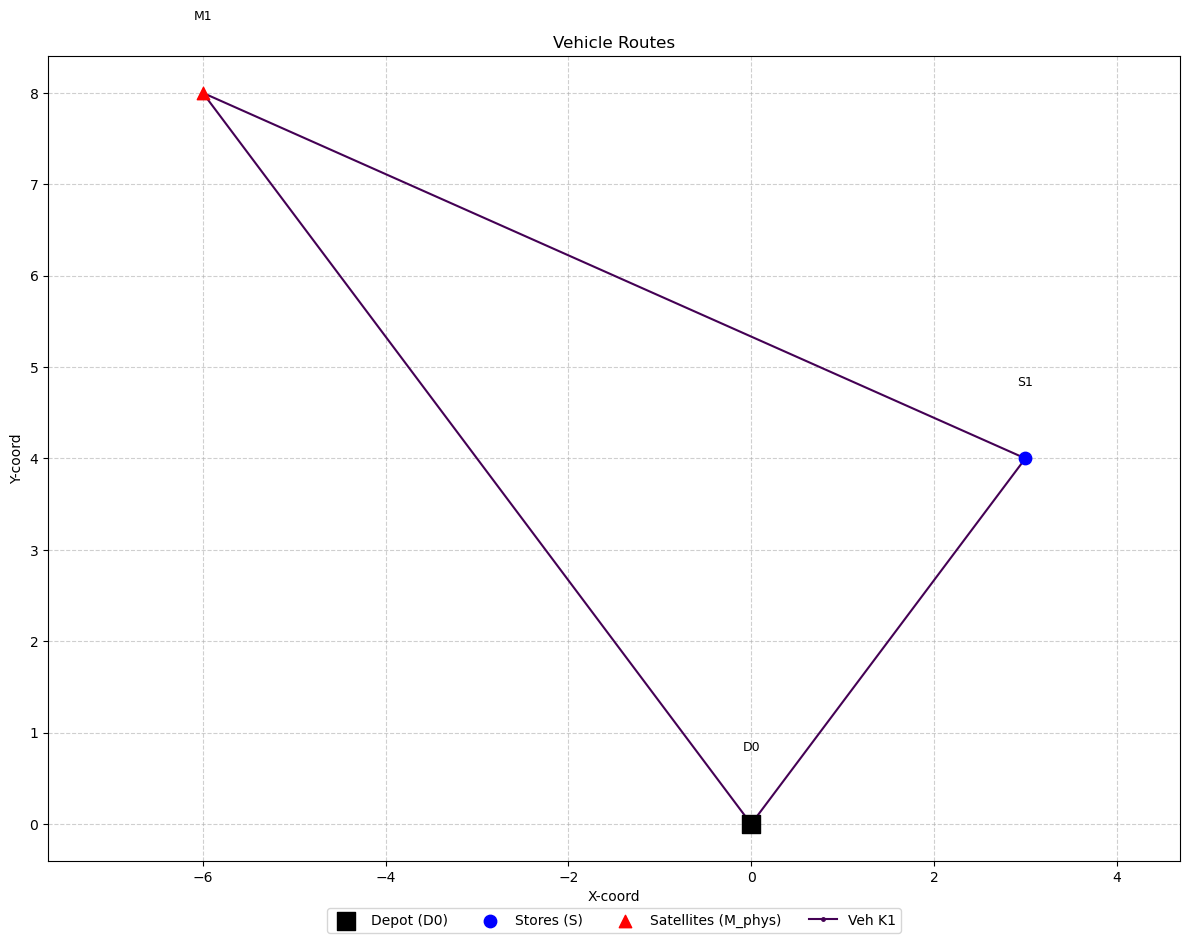

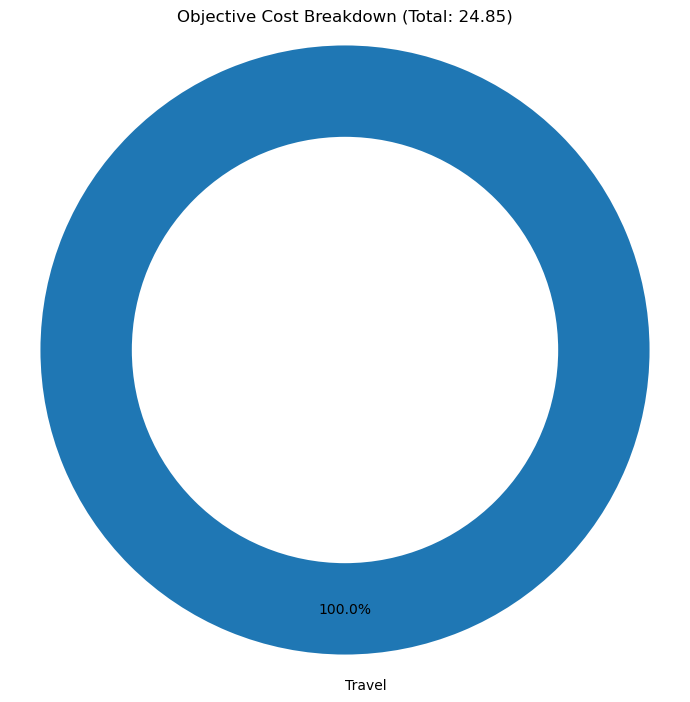


Verification Calculations (Single Vehicle Scenario):
  Expected Route: D0->S1->M1->D0
  Expected Travel Cost: 24.85
  Arrival S1: 5.00 (Hard TW: 15.00) -> OK
  Arrival M1: 16.85 (Soft TW: 30.00) -> OK
  Expected Penalty Cost for this scenario: 0.00
  Expected Total Cost for this scenario (0 split cost): 24.85

VERIFICATION NOTE: Solver Objective (24.85) vs Calculated Single Vehicle Scenario (24.85).
  Difference: 0.00
  This simple check assumes one vehicle visits S then M. The optimal solution might use splits or different routing.

--- Basic Run: Generating Larger & More Complex Instance (Strict Table 2 Alignment) ---
Instance: 3S, 2M_phys (5 cust). Demand Vol: 92.00. Fleet: 2 (Cap: 120). Eq1 Min Veh: 1

--- Running Basic Instance (Strict Table 2 Alignment, Targeting ~75s) ---
Set parameter TimeLimit to value 90
Set parameter MIPGap to value 0.01
Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(

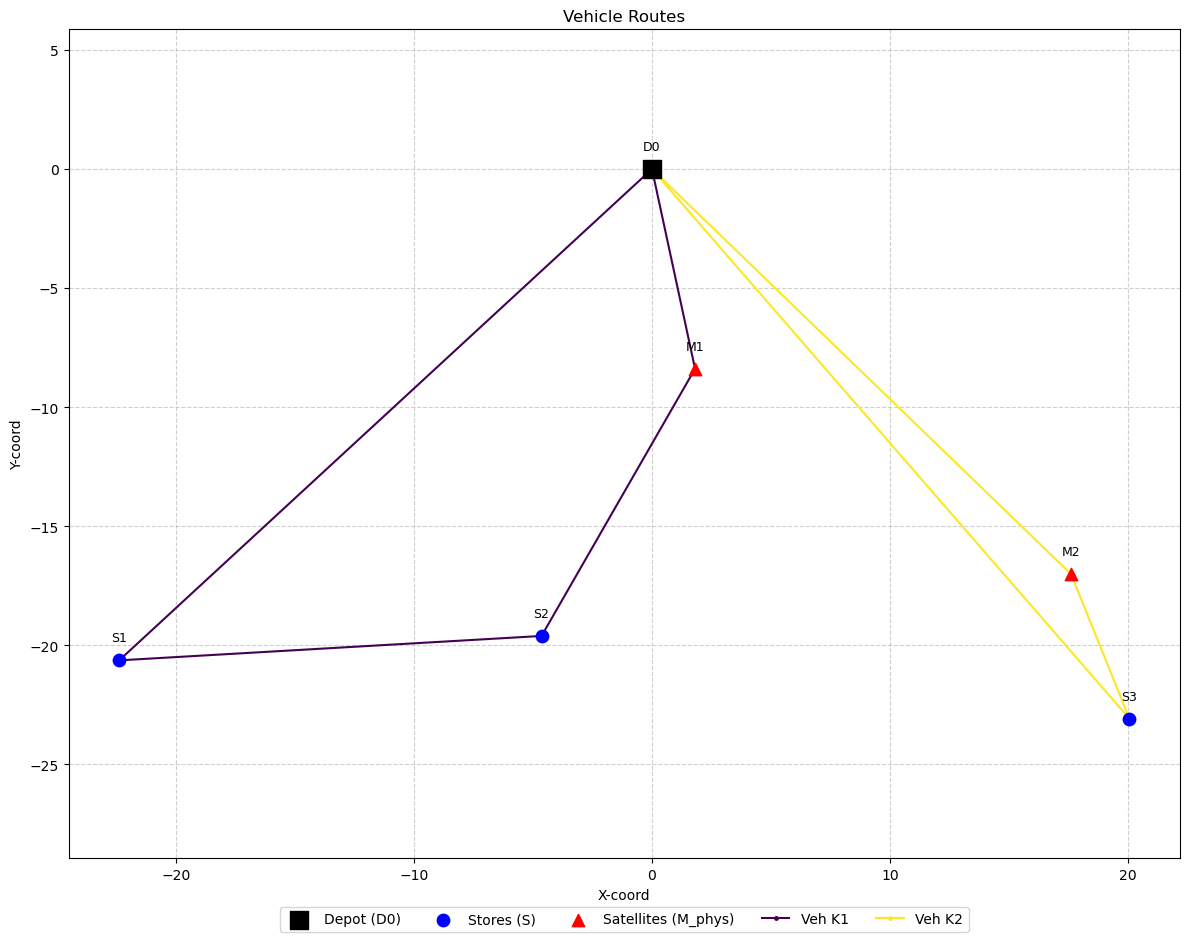

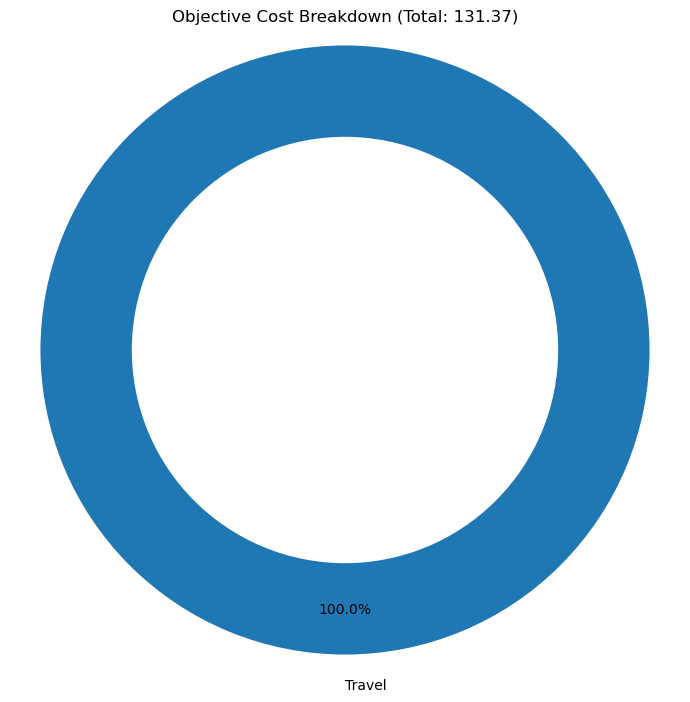

In [3]:
# Block 2: Basic Run & Verification (Using Corrected Functions from Block 1)

# --- Run Verification Instance ---
print("\n--- Running Verification Instance (Strict Table 2 Alignment) ---")
verify_results_final = solve_vrpor_table2_final(verify_instance_final, time_limit=90, log_to_console=0, mip_gap=0.0001) # Increased time for non-convex
print_results_summary(verify_results_final)
if verify_results_final.get("routes"):
     plot_solution_routes(verify_results_final)
     plot_cost_breakdown(verify_results_final)

# Verification Check
if verify_results_final.get('objective_value') is not None and verify_results_final.get('status_code') == GRB.OPTIMAL:
    depot_v = verify_instance_final['depot_node']; store_v = verify_instance_final['S_stores'][0]
    satellite_v = verify_instance_final['M_phys_satellites'][0]; dist_v = verify_instance_final['d_ij']
    t_travel_v = verify_instance_final['t_ij']; o_serv_v = verify_instance_final['o_i']; l_dead_v = verify_instance_final['l_i'] # Corrected keys

    expected_route_cost_single_veh = dist_v[depot_v, store_v] + dist_v[store_v, satellite_v] + dist_v[satellite_v, depot_v]
    arr_s1_single_veh = t_travel_v[depot_v,store_v]
    dep_s1_single_veh = arr_s1_single_veh + o_serv_v[store_v]
    arr_m1_single_veh = dep_s1_single_veh + t_travel_v[store_v,satellite_v]
    
    penalty_single_veh = 0
    if arr_m1_single_veh > l_dead_v[satellite_v]:
        lateness = arr_m1_single_veh - l_dead_v[satellite_v]
        vol_Y_at_m1 = verify_instance_final["V_b"][verify_instance_final["B_order_types"][0]] * verify_instance_final["D_i_b"][(satellite_v, verify_instance_final["B_order_types"][0])]
        penalty_single_veh = verify_instance_final["p_u"] * lateness * vol_Y_at_m1
        
    expected_total_cost_single_veh = expected_route_cost_single_veh + penalty_single_veh
    # No split cost for single vehicle serving all

    print(f"\nVerification Calculations (Single Vehicle Scenario):");
    print(f"  Expected Route: {depot_v}->{store_v}->{satellite_v}->{depot_v}");
    print(f"  Expected Travel Cost: {expected_route_cost_single_veh:.2f}")
    print(f"  Arrival {store_v}: {arr_s1_single_veh:.2f} (Hard TW: {l_dead_v[store_v]:.2f}) -> {'OK' if arr_s1_single_veh <= l_dead_v[store_v] else 'FAIL'}")
    print(f"  Arrival {satellite_v}: {arr_m1_single_veh:.2f} (Soft TW: {l_dead_v[satellite_v]:.2f}) -> {'OK' if arr_m1_single_veh <= l_dead_v[satellite_v] else f'LATE by {arr_m1_single_veh - l_dead_v[satellite_v]:.2f}'}")
    print(f"  Expected Penalty Cost for this scenario: {penalty_single_veh:.2f}")
    print(f"  Expected Total Cost for this scenario (0 split cost): {expected_total_cost_single_veh:.2f}")
    
    tolerance = 0.01
    obj_val_results = verify_results_final['objective_value']
    
    # This simple verification might not match if multiple vehicles are optimal or splits are optimal
    print(f"\nVERIFICATION NOTE: Solver Objective ({obj_val_results:.2f}) vs Calculated Single Vehicle Scenario ({expected_total_cost_single_veh:.2f}).")
    print(f"  Difference: {abs(obj_val_results - expected_total_cost_single_veh):.2f}")
    print(f"  This simple check assumes one vehicle visits S then M. The optimal solution might use splits or different routing.")
    obj_comp_v = verify_results_final.get("objective_components")
    if obj_comp_v:
        if obj_comp_v.get('penalty',0) > tolerance: print(f"  Solver Penalty Cost: {obj_comp_v['penalty']:.2f}")
        if obj_comp_v.get('split',0) > tolerance: print(f"  Solver Split Cost: {obj_comp_v['split']:.2f}")
        if len(verify_results_final.get("routes", {})) > 1 : print(f"  Solver used {len(verify_results_final.get('routes', {}))} routes.")

else: print("\nVERIFICATION FAILED: Optimal solution not found for verification instance.")


# --- Basic Run with LARGER, MORE COMPLEX Instance ---
print("\n--- Basic Run: Generating Larger & More Complex Instance (Strict Table 2 Alignment) ---")
basic_params_final = {"num_stores":3, "num_physical_satellites":2, "num_products":2, "num_orders":2, # Reduced for quicker demo
                       "vehicle_capacity_V_star":120, "penalty_pu_param":0.5, "split_ps_param":50.0,
                       "seed":123, "vehicle_buffer": 1} # Buffer 1
basic_instance_final = generate_instance_table2_final(**basic_params_final)
print(f"Instance: {len(basic_instance_final['S_stores'])}S, {len(basic_instance_final['M_phys_satellites'])}M_phys ({len(basic_instance_final['N_cust_customers'])} cust). Demand Vol: {basic_instance_final['total_demand_vol_overall']:.2f}. Fleet: {len(basic_instance_final['VF_fleet'])} (Cap: {basic_instance_final['V_star']}). Eq1 Min Veh: {basic_instance_final['min_vehicles_eq1']}")

print("\n--- Running Basic Instance (Strict Table 2 Alignment, Targeting ~75s) ---")
basic_results_final = solve_vrpor_table2_final(basic_instance_final, time_limit=90, mip_gap=0.01, log_to_console=1) # Increased time for non-convex
print_results_summary(basic_results_final)

print("\n--- Visualizing Basic Run Results (Strict Table 2 Alignment) ---")
if basic_results_final.get("routes"): plot_solution_routes(basic_results_final)
if basic_results_final.get("objective_components"): plot_cost_breakdown(basic_results_final)

Code Block 3: Sophisticated Sensitivity Analysis


--- Block 4: Generating a More Challenging Scenario ---
Generating challenging instance with parameters:
  num_stores: 8
  num_physical_satellites: 5
  num_products: 4
  num_orders: 4
  vehicle_capacity_V_star: 180
  penalty_pu_param: 2.5
  split_ps_param: 75.0
  seed: 2024
  vehicle_buffer: 1

Challenging Instance Details:
  Number of Stores (S): 8
  Number of Physical Satellites (M_phys): 5
  Total Customer Nodes (N_cust): 13
  Number of Product Types (R): 4
  Number of Order Types (B): 4
  Vehicle Capacity (V*): 180
  Total Calculated Demand Volume: 583.00
  Min Vehicles by Eq1 (before buffer): 4
  Actual Fleet Size |VF| (with buffer): 5
  Max Big-M for Time Constraints: 299.15

--- Running Challenging Instance ---
Attempting to solve with Time Limit: 300s, MIP Gap: 5.0%
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) C

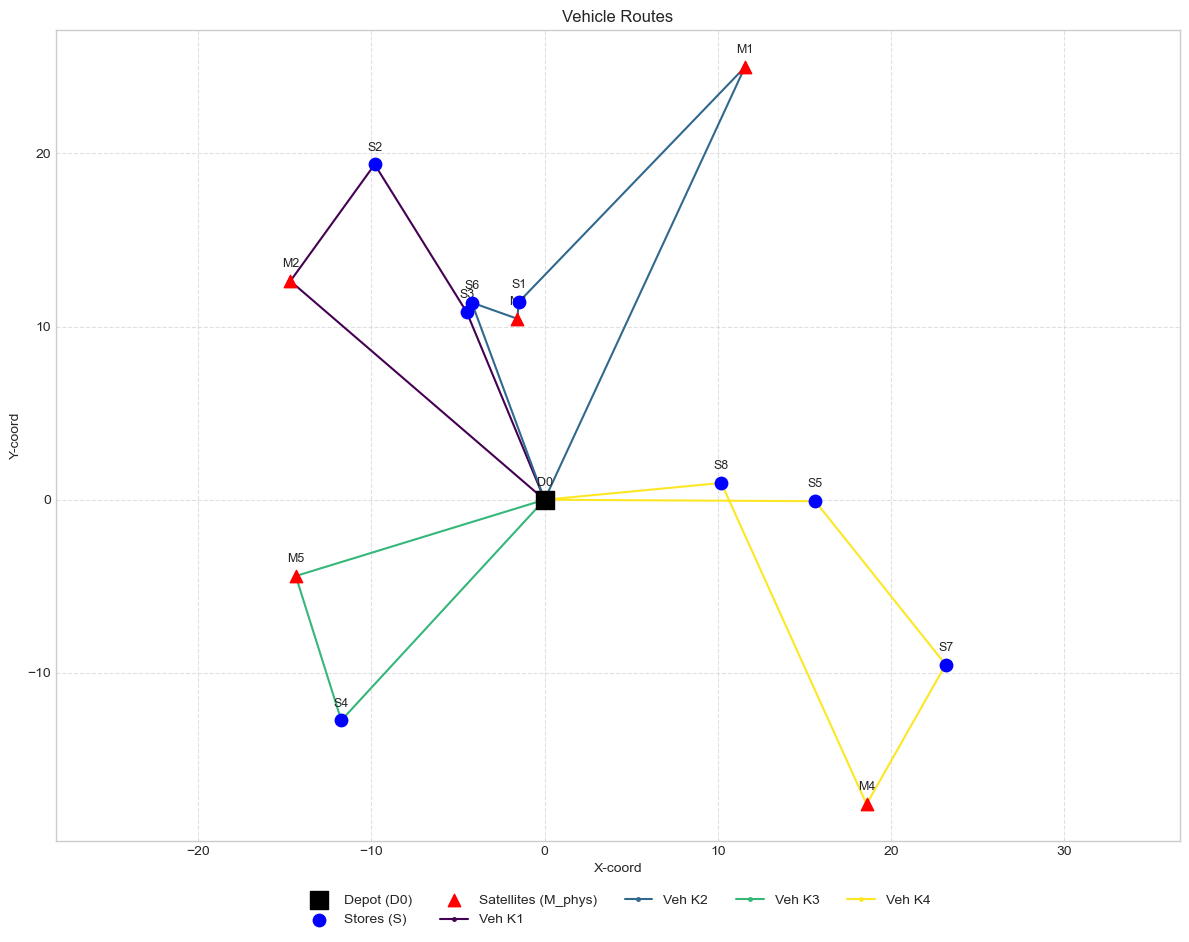

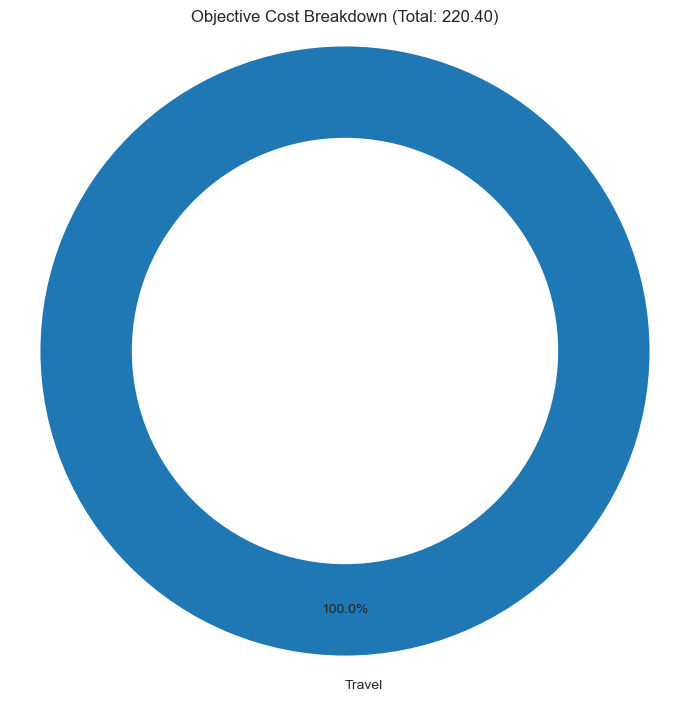


--- End of Challenging Scenario (Block 4) ---


In [5]:
# Block 4: Generating and Running a More Challenging Scenario

print("\n--- Block 4: Generating a More Challenging Scenario ---")

# Parameters for a more challenging instance:
# - More stores and satellites
# - More product and order types
# - Vehicle capacity that is not overly generous, to encourage some splits or efficient packing
# - A mix of time window tightness (some easy, some harder to meet)
# - Higher penalty for lateness and significant cost for splits
# - Slightly larger coordinate range for more spread-out locations

challenging_params = {
    "num_stores": 8,                      # Increased from 3/6
    "num_physical_satellites": 5,         # Increased from 2/4
    "num_products": 4,                    # Increased from 2/3
    "num_orders": 4,                      # Increased from 2/3
    "vehicle_capacity_V_star": 180,       # Moderate capacity
    "penalty_pu_param": 2.5,              # Higher penalty for lateness
    "split_ps_param": 75.0,               # Significant cost for split deliveries
    "seed": 2024,                         # New seed for variety
    "vehicle_buffer": 1                   # Allow one extra vehicle over the minimum calculation
}

# Override some generation defaults within the instance generation if needed,
# or rely on the ranges set in generate_instance_table2_final.
# For this example, we'll let generate_instance_table2_final handle most randomness
# but we've increased the scale via the parameters above.

# If you want to ensure tighter deadlines specifically:
# You could modify generate_instance_table2_final to accept a deadline tightness factor,
# or post-process the generated instance. For now, we'll rely on its internal randomness
# with the increased node count to create complexity.

print("Generating challenging instance with parameters:")
for key, value in challenging_params.items():
    print(f"  {key}: {value}")

challenging_instance = generate_instance_table2_final(**challenging_params)

print(f"\nChallenging Instance Details:")
print(f"  Number of Stores (S): {len(challenging_instance['S_stores'])}")
print(f"  Number of Physical Satellites (M_phys): {len(challenging_instance['M_phys_satellites'])}")
print(f"  Total Customer Nodes (N_cust): {len(challenging_instance['N_cust_customers'])}")
print(f"  Number of Product Types (R): {len(challenging_instance['R_product_types'])}")
print(f"  Number of Order Types (B): {len(challenging_instance['B_order_types'])}")
print(f"  Vehicle Capacity (V*): {challenging_instance['V_star']}")
print(f"  Total Calculated Demand Volume: {challenging_instance['total_demand_vol_overall']:.2f}")
print(f"  Min Vehicles by Eq1 (before buffer): {challenging_instance['min_vehicles_eq1']}")
print(f"  Actual Fleet Size |VF| (with buffer): {len(challenging_instance['VF_fleet'])}")
print(f"  Max Big-M for Time Constraints: {challenging_instance['M_TIME_BIG']:.2f}")


# --- Running the Challenging Instance ---
# Expect this to take longer. Adjust time_limit and mip_gap accordingly.
# For a truly challenging instance, optimality might not be reached quickly.

# Note: Due to the NonConvex=2 setting, Gurobi attempts to find a global optimum.
# This can be very time-consuming for larger or more complex non-convex MIQCPs.
# If it takes too long, you might consider:
# 1. Increasing the mip_gap (e.g., 0.05 for 5% gap).
# 2. Reducing the time_limit and accepting a feasible, but possibly suboptimal, solution.
# 3. For practical applications, heuristic approaches (like ALNS mentioned in the paper)
#    are often used for larger VRPs, especially non-convex ones.

print("\n--- Running Challenging Instance ---")
# Set a reasonable time limit for demonstration. You might need to increase this significantly
# or accept a larger MIP gap for very complex problems.
challenging_time_limit = 300  # 5 minutes
challenging_mip_gap = 0.05     # 5% MIP gap tolerance

print(f"Attempting to solve with Time Limit: {challenging_time_limit}s, MIP Gap: {challenging_mip_gap*100}%")

challenging_results = solve_vrpor_table2_final(
    challenging_instance,
    time_limit=challenging_time_limit,
    mip_gap=challenging_mip_gap,
    log_to_console=1  # Show Gurobi log for this run
)

print_results_summary(challenging_results)

print("\n--- Visualizing Challenging Instance Results ---")
if challenging_results.get("status_code") in [GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.INTERRUPTED] and challenging_results.get("routes"):
    plot_solution_routes(challenging_results)
    if challenging_results.get("objective_components"): # Ensure components exist before plotting
        plot_cost_breakdown(challenging_results)
else:
    print("No routes to plot for the challenging instance (likely due to infeasibility or failure to find a solution within limits).")

print("\n--- End of Challenging Scenario (Block 4) ---")